In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
# drop uncertainty columnns in Berkeley Earth (df1)
def df1Preprocess(df):
  df = df.copy()
  # df.drop(columns=['LandAverageTemperatureUncertainty', 'LandMaxTemperatureUncertainty', 
  #                    'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperatureUncertainty'], axis=1)

  del df['LandAverageTemperatureUncertainty']
  del df['LandMaxTemperatureUncertainty']
  del df['LandMinTemperatureUncertainty']
  del df['LandAndOceanAverageTemperatureUncertainty']

  # convert celsius values to fahrenheit
  def convertToCelsius(x):
    x = (x *1.8) + 32
    return float(x)
  
  df['LandAverageTemperature'] = df['LandAverageTemperature'].apply(convertToCelsius)
  df['LandMaxTemperature'] = df['LandMaxTemperature'].apply(convertToCelsius)
  df['LandMinTemperature'] = df['LandMinTemperature'].apply(convertToCelsius)
  df['LandAndOceanAverageTemperature'] = df['LandAndOceanAverageTemperature'].apply(convertToCelsius)

  # change dt to DateTime
  df['dt'] = pd.to_datetime(df['dt'])
  df['Month'] = df['dt'].dt.month
  df['Year'] = df['dt'].dt.year
  df = df.drop('dt', axis = 1)
  df = df.drop('Month', axis = 1)
  df = df[df.Year >= 1850]
  df = df.set_index(['Year'])
  df = df.dropna()
  return df


# Uploading Datasets

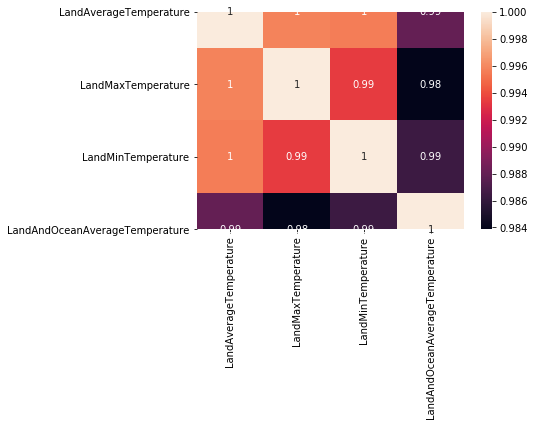

In [ ]:
# Berkeley Earth Dataset
file1 = open('GlobalTemperatures.csv', 'r')
df1 = pd.read_csv(file1)
df1 = df1Preprocess(df1)
# df1.head(20)

# plot correlation matrix
df1CorrMatrix = df1.corr()
sns.heatmap(df1CorrMatrix, annot=True)
plt.show()

# Training

In [ ]:
# setting our target, Y, as the land and ocean average temperature
target = 'LandAndOceanAverageTemperature'
Y = df1[target]
#feature matrix
X = df1.copy()
del X[target]
# X.drop(columns = [target], axis = 1)
X.head(20)

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature
Year,,,
1850,33.3482,46.8356,26.2292
1850,37.5278,49.9460,27.8762
1850,40.9172,50.6246,28.5710
1850,44.9906,55.2812,33.8324
1850,50.0072,60.1790,38.8598
1850,55.6700,66.1028,44.7908
1850,58.0856,66.6194,46.4252
1850,57.2702,65.2586,45.3308
1850,52.7090,60.5228,40.1594


In [ ]:
# create train and test sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42) 


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(1494, 3)
(498, 3)
(1494,)
(498,)


In [ ]:
# establish baseline mean absolute error
y_pred = [Y_train.mean()] * len(Y_train)
print('Baseline MAE: ', round(mean_absolute_error(Y_train, y_pred), 5))

Baseline MAE:  2.03719


# Models

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
lm = make_pipeline(
    StandardScaler(), 
    LinearRegression(),
)
lm.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Random Forest

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

In [ ]:
forestModel = make_pipeline(
    SelectKBest(k='all'),
    StandardScaler(),
    RandomForestRegressor(
        # n_estimators=100,
        # max_depth=50,
        # random_state=77,
        # n_jobs=-1
    )
)

forestModel.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k='all',
                             score_func=<function f_classif at 0x7f1e89ecdb00>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_s

# New Mean Absolute Error

In [ ]:
print('Linear Regression Training MAE: ', round(mean_absolute_error(Y_train, lm.predict(X_train)), 5))
print('Linear Regression Test MAE: ', round(mean_absolute_error(Y_val, lm.predict(X_val)), 5))

Linear Regression Training MAE:  0.2803
Linear Regression Test MAE:  0.28201


In [ ]:
print('Random Forest Training MAE: ', mean_absolute_error(Y_train, forestModel.predict(X_train)))
print('Random Forest Test MAE: ', mean_absolute_error(Y_val, forestModel.predict(X_val)))

Random Forest Training MAE:  0.09307292771084573
Random Forest Test MAE:  0.24686410843373377


# Metrics

In [ ]:
y_pred = lm.predict(X_val)
errors = abs(y_pred - Y_val)

# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_train)
# calculate andd display accuracy
accuracy = 100 - np.mean(mape)
print('Linear Regression Model Prediction Accuracy: ', round(accuracy, 2), '%.')

Linear Regression Model Prediction Accuracy:  99.52 %.


In [ ]:
y_pred = forestModel.predict(X_val)
errors = abs(y_pred - Y_val)

mape = 100 * (errors / Y_train)
accuracy = 100 - np.mean(mape)
print('Random Forest Regressor Model Prediction Accuracy: ', round(accuracy, 2), '%.')

Random Forest Regressor Model Prediction Accuracy:  99.58 %.


# Model Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {'selectkbest__k': range(5)}

rs = RandomizedSearchCV(
    forestModel,
    param_distributions=params,
    n_iter=5,
    n_jobs=-1,
    cv=10
)

rs.fit(X_train, Y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('selectkbest',
                                              SelectKBest(k='all',
                                                          score_func=<function f_classif at 0x7f1e89ecdb00>)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                     

In [ ]:
best_model = rs.best_estimator_

In [ ]:
print('Training MAE: ', mean_absolute_error(Y_train, best_model.predict(X_train)))
print('Validation MAE: ', mean_absolute_error(Y_val, best_model.predict(X_val)))

Training MAE:  0.09224386746988143
Validation MAE:  0.24244597590361364


In [ ]:
y_pred = best_model.predict(X_val)
errors = abs(y_pred - Y_val)

mape = 100 * (errors / Y_train)
accuracy = 100 - np.mean(mape)
print('RandomSearchCV Best Model Prediction Accuracy: ', round(accuracy, 2), '%.')

RandomSearchCV Best Model Prediction Accuracy:  99.59 %.


# Visuals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'LandAverageTemperature'

isolated = pdp_isolate(
    model=forestModel,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1e8436bdd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1e843add50>})

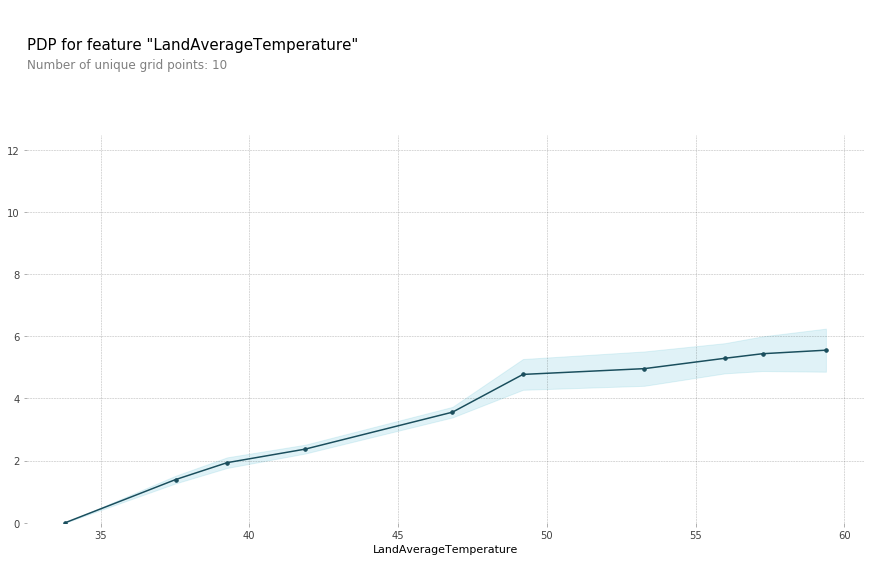

In [ ]:
pdp_plot(isolated, feature_name=feature)